In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/FEM')
%load_ext autoreload

In [2]:
%autoreload 2
from FEMOL import RectangleQuadMesh, FEM_Problem, TOPOPT_Problem, PlateBendingResults
from FEMOL_utils import *
from FEMOL_materials import general_carbon
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, clear_output
np.set_printoptions(linewidth=150)
%matplotlib inline

# Developping Notebook

## Mesh

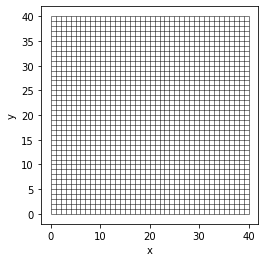

In [47]:
# Mesh
nelx = 40
nely = 40
Lx = nelx
Ly = nely
mesh = RectangleQuadMesh(nelx, nely, Lx, Ly)
mesh.plot()

## Material Proprietes

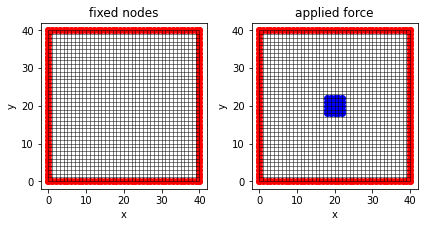

In [48]:
%matplotlib inline

# Layups
layup_base = [90,0,45,-45,0,90]
layup_coating = [90,0,90,0]
material = general_carbon()

# FEM Problem
Plate_FEM = FEM_Problem(mesh)

# Base stiffness matrix
Ke_base = Plate_FEM.complete_plate_Ke(layup=layup_base, material=material, Gs=1000., out=True)

# Problem conditions
fixed_domain = create_domain([0, Lx], [[0, Ly]])
Plate_FEM.add_fixed_domain(fixed_domain)

fixed_domain = create_domain([[0, Lx]], [0, Ly])
Plate_FEM.add_fixed_domain(fixed_domain)

Plate_FEM.assemble_plate_K()
Plate_FEM.fix_boundary()

fig, (ax1, ax2) = plt.subplots(1,2)

plt.sca(ax1)
Plate_FEM.plot()
plt.title('fixed nodes')

force = [0, 0, -5000, 0, 0, 0]
force_domain = create_domain([[9*Lx/20, 11*Lx/20]], [[9*Ly/20, 11*Ly/20]])
Plate_FEM.add_forces(force, force_domain)

plt.sca(ax2)
Plate_FEM.plot()
plt.title('applied force')

plt.tight_layout()
plt.show()

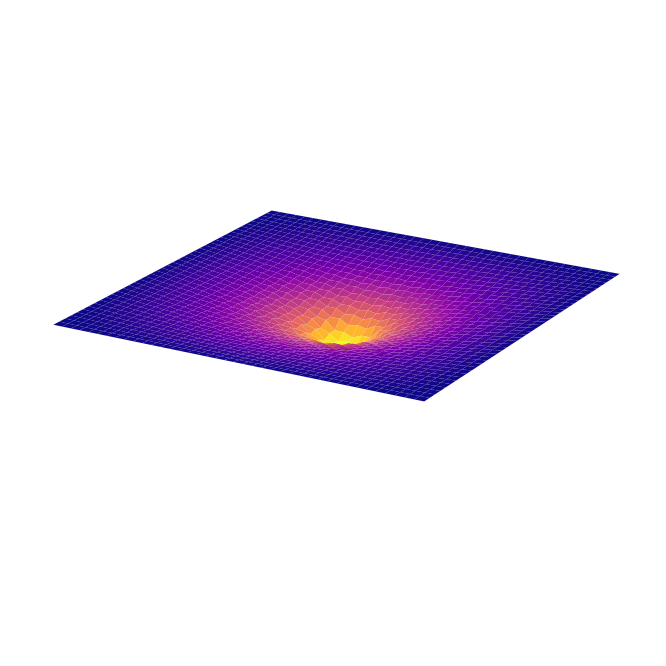

In [50]:
Result = Plate_FEM.solve()
Result.Z_displacement_3D(scale=1, azim=-60, elev=20)

## Optimizing the coating layer height

In [51]:
# Heights
base_ho = material.hi*len(layup_base)
coating_ho = material.hi*len(layup_coating)
min_height = base_ho/2 + coating_ho/2 # Specify the middle plane height
max_height = 4

TOPOPT_height_parameters = {}
TOPOPT_height_parameters['coating_layup'] = [90,0,90,0]
TOPOPT_height_parameters['hmin'] = min_height
TOPOPT_height_parameters['hmax'] = max_height
TOPOPT_height_parameters['coating_material'] = general_carbon()
TOPOPT_height_parameters['out_of_plane_shear'] = 1000.

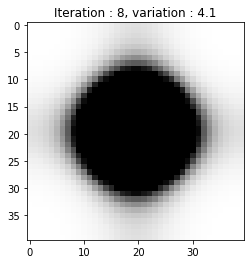

In [52]:
# Creating the topology optimisation problem
TOPOPT_height = TOPOPT_Problem(Plate_FEM, volfrac=0.4, penal=0.7, ke_base=Ke_base, height_dict=TOPOPT_height_parameters)
result = TOPOPT_height.solve_coating_height(converge=0.05)

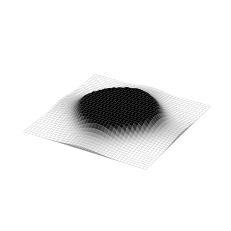

In [54]:
result.plot_height(azim=-60, elev=30)